## 1. Context Analysis Setup

**Methods for Research Question 2**  

This portion of the notebook implements part of our _contextual analysis_, where we compare the semantic content of scientific papers to the semantic content of SBIR project descriptions. 

- We begin by importing the core libraries needed (NumPy, pandas, etc.).  
- We set up environment variables (e.g., `UMAP = True`) that control whether the code will use UMAP or PCA for dimensionality reduction.  
- We also define paths to load or save pickled data structures (e.g., computed distances).

The goal here is to **load** our embeddings, prepare them for further analysis, and organize them for subsequent computations such as the Triangular Ratio in Equation (9) of the paper.

In [63]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

PICKLES_ADDRESS = 'pickles/'
LAG_DATA_ADDRESS = '../lag_data/'
TEMP_ADDRESS = '../temp/'
UMAP = False
LOADING_PARAM = False

if UMAP:
    TVD_ADDRESS = TEMP_ADDRESS + 'parallel/UMAP/TVDs/'
    JSD_ADDRESS = TEMP_ADDRESS + 'parallel/UMAP/JSDs/'
    HLD_ADDRESS = TEMP_ADDRESS + 'parallel/UMAP/HLDs/'
else:
    TVD_ADDRESS = '../../data/parallel/TVDs/'
    JSD_ADDRESS = '../../data/parallel/JSDs/'
    HLD_ADDRESS = '../../data/parallel/HLDs/'

print('TVD_ADDRESS: ', TVD_ADDRESS)
print('JSD_ADDRESS: ', JSD_ADDRESS)
print('HLD_ADDRESS: ', HLD_ADDRESS)

TVD_ADDRESS:  ../../data/parallel/TVDs/
JSD_ADDRESS:  ../../data/parallel/JSDs/
HLD_ADDRESS:  ../../data/parallel/HLDs/


## 2. Loading and Preprocessing Data

**Data and Semantic Representations**  

In this block, we:  
1. Load all pickle files containing MeSH hierarchy information, frequency statistics, and citation data for PubMed (papers) and SBIR (projects).  
2. Filter out DUIs (MeSH terms) that have no meaningful frequency across the target years.  
3. Initialize (or load) 3D tensors that capture our year-by-year distance metrics (TVD, JSD, and HLD).  

Each tensor’s shape is `(num_terms, 12, 12)`, reflecting the 12-year comparison grid (2010–2021). We store or retrieve these tensors to avoid recomputing distances for each run.

In [37]:
years = [str(year) for year in range(2010, 2022)]
correlation_lags = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7, 8, 9, 10, 11]
print('years:', years)

with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
    print('dui2children:', len(dui2children))
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))
with open(PICKLES_ADDRESS + 'heading2dui_final.pkl', 'rb') as handle:
    dui2name = pickle.load(handle)
    print('dui2name:', len(dui2name))
with open(PICKLES_ADDRESS + 'dui2header_final.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
    print('name2dui:', len(name2dui))
with open(PICKLES_ADDRESS + 'dui2level_final.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)
    print('dui2level:', len(dui2level))
with open(PICKLES_ADDRESS + 'level2duis_final.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
    print('level2duis:', len(level2duis))
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2trail = pickle.load(handle)
    print('dui2trail:', len(dui2trail))
with open(PICKLES_ADDRESS + 'dui_intersection_final.pkl', 'rb') as handle:
    dui_intersections = pickle.load(handle)
    print('dui_intersections:', len(dui_intersections))
with open(PICKLES_ADDRESS + 'excluded_duis_final.pkl', 'rb') as handle:
    excluded_duis = pickle.load(handle)
    print('excluded_duis:', len(excluded_duis))
with open(PICKLES_ADDRESS + 'dui2pubfreq.pkl', 'rb') as handle:
    dui2pubfreq = pickle.load(handle)
    print('dui2pubfreq:', len(dui2pubfreq))
with open(PICKLES_ADDRESS + 'dui2sbfreq.pkl', 'rb') as handle:
    dui2sbfreq = pickle.load(handle)
    print('dui2sbfreq:', len(dui2sbfreq))
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
    print('dui2pubfreqchild:', len(dui2pubfreqchild))
with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
    print('dui2sbfreqchild:', len(dui2sbfreqchild))
with open(TEMP_ADDRESS + 'dui2pubcit.pkl', 'rb') as handle:
    dui2pubcit = pickle.load(handle)
    print('dui2pubcit:', len(dui2pubcit))
with open(TEMP_ADDRESS + 'dui2sbcit.pkl', 'rb') as handle:
    dui2sbcit = pickle.load(handle)
    print('dui2sbcit:', len(dui2sbcit))
with open(TEMP_ADDRESS + 'dui2pubcitchild.pkl', 'rb') as handle:
    dui2pubcitchild = pickle.load(handle)
    print('dui2pubcitchild:', len(dui2pubcitchild))
with open(TEMP_ADDRESS + 'dui2sbcitchild.pkl', 'rb') as handle:
    dui2sbcitchild = pickle.load(handle)
    print('dui2sbcitchild:', len(dui2sbcitchild))

dui2children: 29432
dui2parents: 29307
dui2name: 29307
name2dui: 29307
dui2level: 29307
level2duis: 14
dui2trail: 29432
dui_intersections: 29307
excluded_duis: 723
dui2pubfreq: 29307
dui2sbfreq: 29307
dui2pubfreqchild: 29307
dui2sbfreqchild: 29307
dui2pubcit: 29307
dui2sbcit: 29307
dui2pubcitchild: 29307
dui2sbcitchild: 29307


In [64]:
# store all duis that have no frequency at any year of the dui2pubfreq dictionary and store them in a list called exduis
exduis = {}
for dui in dui2sbfreq:
    c = 0
    for year in years:
        c += len(dui2sbfreq[dui][year])
    if c == 0:
        exduis[dui] = True
    else:
        exduis[dui] = False

len(exduis), c

(29307, 0)

In [65]:
# count how many excuis have False and True values
c = 0
incduis = []
dui2tensoridx = {}
tensoridx2dui = {}
for dui in exduis:
    if exduis[dui] == False:
        incduis.append(dui)
        dui2tensoridx[dui] = c
        tensoridx2dui[c] = dui
        c += 1
print(c, 'DUIs remained.', len(incduis), len(dui2tensoridx), len(tensoridx2dui))

10873 DUIs remained. 10873 10873 10873


In [66]:
if not LOADING_PARAM:
    #make three numpy array with size c, 12, 12 and name them tensor_TVD, tensor_JSD, tensor_HLD
    tensor_TVD = np.ones((c, 12, 12))
    tensor_JSD = np.ones((c, 12, 12))
    tensor_HLD = np.ones((c, 12, 12))

    # for each dui in exduis, load the corresponding TVD, JSD and HLD txt files and store them in the tensors
    c = 0
    for i, dui in tqdm(enumerate(incduis)):
        for pm_year_idx, pm_year in enumerate(years):
            for sb_year_idx, sb_year in enumerate(years):
                try:
                    tensor_TVD[i, pm_year_idx, sb_year_idx] = np.loadtxt(TVD_ADDRESS + '{}_{}_{}_TVD.txt'.format(dui, pm_year, sb_year))
                    tensor_JSD[i, pm_year_idx, sb_year_idx] = np.loadtxt(JSD_ADDRESS + '{}_{}_{}_JSD.txt'.format(dui, pm_year, sb_year))
                    tensor_HLD[i, pm_year_idx, sb_year_idx] = np.loadtxt(HLD_ADDRESS + '{}_{}_{}_HLD.txt'.format(dui, pm_year, sb_year))
                except:
                     pass
    #save the tensors in data/pickles
    if UMAP:
        with open(PICKLES_ADDRESS + 'tensor_UMAP_TVD.pkl', 'wb') as handle:
            pickle.dump(tensor_TVD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_JSD.pkl', 'wb') as handle:
            pickle.dump(tensor_JSD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_HLD.pkl', 'wb') as handle:
            pickle.dump(tensor_HLD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tensors saved.')
    else:
        with open(PICKLES_ADDRESS + 'tensor_PCA_TVD.pkl', 'wb') as handle:
            pickle.dump(tensor_TVD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_PCA_JSD.pkl', 'wb') as handle:
            pickle.dump(tensor_JSD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'tensor_PCA_HLD.pkl', 'wb') as handle:
            pickle.dump(tensor_HLD, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tensors saved.')
else:
    print('Loading tensors...')
    if UMAP:
        with open(PICKLES_ADDRESS + 'tensor_UMAP_TVD.pkl', 'rb') as handle:
            TVD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_JSD.pkl', 'rb') as handle:
            JSD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_UMAP_HLD.pkl', 'rb') as handle:
            HLD_diffs = pickle.load(handle)
    else:
        #load the tensors
        with open(PICKLES_ADDRESS + 'tensor_PCA_TVD.pkl', 'rb') as handle:
            TVD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_PCA_JSD.pkl', 'rb') as handle:
            JSD_diffs = pickle.load(handle)
        with open(PICKLES_ADDRESS + 'tensor_PCA_HLD.pkl', 'rb') as handle:
            HLD_diffs = pickle.load(handle)
    print(TVD_diffs.shape, JSD_diffs.shape, HLD_diffs.shape)

10873it [09:25, 19.22it/s]

Tensors saved.


## 3. Converting Distances to Similarities & Triangular Ratio

**Triangular Ratio Calculation**  

- We convert the distance metrics (TVD, JSD, HLD) into similarity measures by subtracting them from **1**.  
- Next, we define a helper function `cal_triangular_ratio(...)` that implements Equation (9) from the paper. This function computes whether the historical scientific content (upper triangle) is more similar to future industrial content than the opposite scenario (lower triangle).  

A ratio > 1 indicates a stronger science-to-industry context influence, while a ratio < 1 suggests the reverse.

In [74]:
#turn distance-containing tensors into similarity-containing tensors
tensor_TVD = 1 - TVD_diffs
tensor_JSD = 1 - JSD_diffs
tensor_HLD = 1 - HLD_diffs

print('tensor_TVD:', tensor_TVD.shape)
print('tensor_JSD:', tensor_JSD.shape)
print('tensor_HLD:', tensor_HLD.shape)

tensor_TVD: (10873, 12, 12)
tensor_JSD: (10873, 12, 12)
tensor_HLD: (10873, 12, 12)


In [75]:
def cal_triangular_ratio(score_matrix):
    ps_sims = []
    sp_sims = []
    for i in range(score_matrix.shape[0]):
        for j in range(score_matrix.shape[1]):
            sim = score_matrix[i, j]
            if j > i:
                ps_sims.append(sim)
            else:
                sp_sims.append(sim)
    return (np.sum(ps_sims) + 1) / (np.sum(sp_sims) + 1)

def cal_triangular_ratio_yearly(score_matrix):
    all_triangular_scores = {year: [] for year in years[:-1]}
    for idx, year in enumerate(years[:-1]):
        sub_matrix = score_matrix[idx:, idx:]
        triangular_ratio = cal_triangular_ratio(sub_matrix)
        all_triangular_scores[year] = triangular_ratio
    return all_triangular_scores

In [76]:
#calculate the triangular ratio for each dui
dui2tvdtr = {}
dui2jsdtr = {}
dui2hldtr = {}
for i in tqdm(range(len(tensor_TVD))):
    dui2tvdtr[tensoridx2dui[i]] = cal_triangular_ratio_yearly(tensor_TVD[i])
    dui2jsdtr[tensoridx2dui[i]] = cal_triangular_ratio_yearly(tensor_JSD[i])
    dui2hldtr[tensoridx2dui[i]] = cal_triangular_ratio_yearly(tensor_HLD[i])

100%|██████████| 10873/10873 [00:06<00:00, 1724.06it/s]


## 4. Computing and Aggregating Triangular Ratios

**Assessment of Topic Hierarchy on Content Association**  

Here, we:  
1. Loop through each MeSH term (DUI) and compute its triangular ratios year-by-year.  
2. Group DUIs by their MeSH depth (from **0** to **13**).  
3. Compute the percentage of DUIs at each depth that exceed a ratio of 1, indicating science→industry influence in context.  

We also measure variability across different time windows (or “sliding windows”), as described in the paper, to assess how robust the triangular ratio is at each depth.

In [77]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
tvd_std, jsd_std, hld_std = [], [], []
max_window_tvd_percents, max_window_jsd_percents, max_window_hld_percents = [], [], []
depth_wise_count = []

for depth in range(max_depth + 1):
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level] if dui in dui2tvdtr]
    depth_wise_count.append(len(dui_subset))
    dui2tvdtr_yearly = {year: [] for year in years[:-1]}
    dui2jsdtr_yearly = {year: [] for year in years[:-1]}
    dui2hldtr_yearly = {year: [] for year in years[:-1]}
    for dui in dui_subset:
        if dui in incduis:
            for k, v in dui2tvdtr[dui].items():
                dui2tvdtr_yearly[k].append(v)
            for k, v in dui2jsdtr[dui].items():
                dui2jsdtr_yearly[k].append(v)
            for k, v in dui2hldtr[dui].items():
                dui2hldtr_yearly[k].append(v)

    yearly_pos, yearly_neg = [], []
    for k, v in dui2tvdtr_yearly.items():
        x1 = len([score for score in v if score > 1])
        x2 = len([score for score in v if score <= 1])
        yearly_pos.append(x1)
        yearly_neg.append(x2)
    yearly_pos_percentage, yearly_neg_percentage = [], []
    for pos, neg in zip(yearly_pos, yearly_neg):
        x1 = pos / (pos + neg + 0.000000001) * 100
        x2 = neg / (pos + neg + 0.000000001) * 100
        yearly_pos_percentage.append(x1)
        yearly_neg_percentage.append(x2)
    max_window_tvd_percents.append(yearly_pos_percentage[0])
    tvd_std.append(np.std(yearly_pos_percentage))

    yearly_pos, yearly_neg = [], []
    for k, v in dui2jsdtr_yearly.items():
        x1 = len([score for score in v if score > 1])
        x2 = len([score for score in v if score <= 1])
        yearly_pos.append(x1)
        yearly_neg.append(x2)
    yearly_pos_percentage, yearly_neg_percentage = [], []
    for pos, neg in zip(yearly_pos, yearly_neg):
        x1 = pos / (pos + neg + 0.000000001) * 100
        x2 = neg / (pos + neg + 0.000000001) * 100
        yearly_pos_percentage.append(x1)
        yearly_neg_percentage.append(x2)
    max_window_jsd_percents.append(yearly_pos_percentage[0])
    jsd_std.append(np.std(yearly_pos_percentage))

    yearly_pos, yearly_neg = [], []
    for k, v in dui2hldtr_yearly.items():
        x1 = len([score for score in v if score > 1])
        x2 = len([score for score in v if score <= 1])
        yearly_pos.append(x1)
        yearly_neg.append(x2)
    yearly_pos_percentage, yearly_neg_percentage = [], []
    for pos, neg in zip(yearly_pos, yearly_neg):
        x1 = pos / (pos + neg + 0.000000001) * 100
        x2 = neg / (pos + neg + 0.000000001) * 100
        yearly_pos_percentage.append(x1)
        yearly_neg_percentage.append(x2)
    max_window_hld_percents.append(yearly_pos_percentage[0])
    hld_std.append(np.std(yearly_pos_percentage))

In [78]:
depth_wise_count = np.array(depth_wise_count[1:])
max_window_tvd_percents = np.array(max_window_tvd_percents[1:])
max_window_jsd_percents = np.array(max_window_jsd_percents[1:])
max_window_hld_percents = np.array(max_window_hld_percents[1:])
tvd_std = np.array(tvd_std[1:])
jsd_std = np.array(jsd_std[1:])
hld_std = np.array(hld_std[1:])

In [79]:
tvd_error_max = np.minimum(max_window_tvd_percents + tvd_std, 99.9) - max_window_tvd_percents
jsd_error_max = np.minimum(max_window_jsd_percents + jsd_std, 99.9) - max_window_jsd_percents
hld_error_max = np.minimum(max_window_hld_percents + hld_std, 99.9) - max_window_hld_percents

tvd_error_max[0] + max_window_tvd_percents[0]

99.9

In [80]:
#save the plot information in a dataframe and save it in data/pickles
df = pd.DataFrame({'depth': range(1, max_depth + 1), 'tvd': max_window_tvd_percents, 'jsd': max_window_jsd_percents, 'hld': max_window_hld_percents, 'tvd_std': tvd_std, 'jsd_std': jsd_std, \
                   'hld_std': hld_std, 'tvd_error_max': tvd_error_max, 'jsd_error_max': jsd_error_max, 'hld_error_max': hld_error_max, 'count': depth_wise_count})
if UMAP:
    address = PICKLES_ADDRESS + 'tvd_jsd_hld_umap_results.pkl'
    df.to_pickle(address)
else:
    address = PICKLES_ADDRESS + 'tvd_jsd_hld_pca_results.pkl'
    df.to_pickle(address)

print('saved', address)

saved pickles/tvd_jsd_hld_pca_results.pkl


In [81]:
#load both dataframes and plot them together
with open(PICKLES_ADDRESS + 'tvd_jsd_hld_umap_results.pkl', 'rb') as handle:
    df_umap = pickle.load(handle)

with open(PICKLES_ADDRESS + 'tvd_jsd_hld_pca_results.pkl', 'rb') as handle:
    df_pca = pickle.load(handle)

print('shape of df_umap:', df_umap.shape)
print('shape of df_pca:', df_pca.shape)

shape of df_umap: (13, 11)
shape of df_pca: (13, 11)


## 5. Visualizing Context Overlap by Hierarchical Depth

**Results for Research Question 2**  

This final step creates a plot illustrating how the percentage of MeSH terms with a Triangular Ratio > 1 changes across increasing topic depth. We overlay error bars (standard deviation and bounds) to show confidence intervals.  

**Plot Interpretation**:  
- **X-axis**: Depth levels in MeSH, with the number of terms at that depth.  
- **Y-axis**: Proportion of terms whose Triangular Ratio (TR) > 1.  
- **Lines**: Different lines for TVD, JSD, and HLD highlight how the embedding reduction choice (UMAP/PCA) and distance metric influence the results.

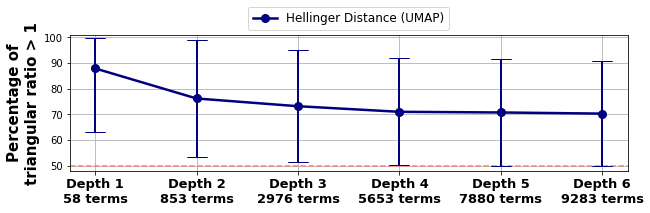

In [85]:
#use df_pca and df_umap to plot the results together
import matplotlib.pyplot as plt

chunk_size = 6
depth_wise_count = depth_wise_count[:chunk_size]
df_pca = df_pca[:chunk_size]
df_umap = df_umap[:chunk_size]

x = ['Depth ' + str(depth + 1) + '\n' + str(each) + ' terms' for depth, each in enumerate(depth_wise_count)]

# Convert relevant data to numpy arrays
x = np.array(x)
df_pca_tvd = np.array(df_pca['tvd'])
df_pca_tvd_std = np.array(df_pca['tvd_std'])
df_pca_tvd_error_max = np.array(df_pca['tvd_error_max'])
df_umap_tvd = np.array(df_umap['tvd'])
df_umap_tvd_std = np.array(df_umap['tvd_std'])
df_umap_tvd_error_max = np.array(df_umap['tvd_error_max'])

df_pca_hld = np.array(df_pca['hld'])
df_pca_hld_std = np.array(df_pca['hld_std'])
df_pca_hld_error_max = np.array(df_pca['hld_error_max'])
df_umap_hld = np.array(df_umap['hld'])
df_umap_hld_std = np.array(df_umap['hld_std'])
df_umap_hld_error_max = np.array(df_umap['hld_error_max'])

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.axhline(y=50, color='salmon', linestyle='--')

# Error bounds for Hellinger Distance UMAP
ax.errorbar(x, df_umap_hld, yerr=[df_umap_hld_std, df_umap_hld_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')
line6, = ax.plot(x, df_umap_hld, marker='o', color='navy', linewidth=2.5, markersize=8, label='Hellinger Distance (UMAP)')
ax.errorbar(x, df_umap_hld, yerr=[df_umap_hld_std, df_umap_hld_error_max], fmt='o', ecolor='navy', elinewidth=2, capsize=10, color='navy')

ax.grid(True)  # Add gridlines
ax.set_ylabel('Percentage of\ntriangular ratio > 1', fontsize=15, weight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, fontsize=13, weight='bold')
ax.set_yticks(range(50, 101, 10))  # Set y-axis ticks from 50 to 100 in steps of 10
ax.set_ylim(48, 101)  # Set y-axis limits from 50% to 100%

plt.legend(loc='upper center', fontsize='large', bbox_to_anchor=(0.5, 1.25), ncol=2)  # Add legend
plt.savefig('tvd_hld_umap_pca.png', dpi=300, bbox_inches='tight')
plt.show()